# Max-Flow Algorithms Empirical Comparison

This notebook compares four max-flow algorithms implemented in this project:

1. **Edmonds-Karp**
2. **Dinic's Algorithm**
3. **Push-Relabel**
4. **Boykov-Kolmogorov (BK)**

We will use the same set of graphs (from the `graphs` folders in each algorithm directory) for the first three algorithms, and run the BK algorithm separately (as it uses its own graph generator). We will empirically compare their runtime as a function of the number of edges and vertices, and visualize the results.

---

In [101]:
# Import required libraries
%matplotlib inline
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [102]:
# Utility to load graphs from a folder (shared for Ford-Fulkerson, Dinic, Push-Relabel)
def load_graph_from_file(filepath):
    """
    Assumes graph file format: first line m n, then m lines of u v c (0-based or 1-based, will auto-detect)
    Returns: n, edge_list (u, v, c)
    """
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
    m, n = map(int, lines[0].split())  # m = num_edges, n = num_vertices
    edge_list = []
    for line in lines[1:]:
        parts = line.split()
        if len(parts) < 3:
            continue
        u, v = map(int, parts[:2])
        c = float(parts[2])
        # Detect 1-based or 0-based
        if u == 0 or v == 0:
            edge_list.append((u, v, c))
        else:
            edge_list.append((u-1, v-1, c))
    return n, edge_list

In [103]:
# Import algorithm implementations
import importlib.util

def import_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Ford-Fulkerson (fordflurkson)
fordflurkson_mod = import_from_path('fordflurkson', './algorithms/fordflurkson/code/ff.py')  # Update path if needed
# Dinic's
dinic_mod = import_from_path('dinics', './algorithms/dinics/code/dinics.py')
# Push-Relabel
push_relabel_mod = import_from_path('push_relabel', './algorithms/push_relabel/code/push_relabel.py')
# BK (Boykov-Kolmogorov)
bk_mod = import_from_path('bk', './Boykov-Kolmogorov/simplified.py')


In [104]:
# Wrappers to run each algorithm on a given graph using the correct constructors
def run_dinic(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    g = dinic_mod.Dinics(n, edge_list, s, t)
    start = time.time()
    flow, _ = g.run()
    end = time.time()
    return flow, end - start

def run_fordflurkson(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    g = fordflurkson_mod.FordFulkerson(n, edge_list, s, t)
    start = time.time()
    flow, _ = g.run()
    end = time.time()
    return flow, end - start

def run_push_relabel(n, edge_list, s=0, t=None):
    if t is None:
        t = n - 1
    # PushRelabel expects a file path, so we need to write the edge_list to a temp file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.txt') as f:
        f.write(f"{len(edge_list)} {n}\n")
        for u, v, c in edge_list:
            f.write(f"{u} {v} {int(c)}\n")
        f.flush()
        temp_path = f.name
    g = push_relabel_mod.PushRelabel(temp_path, s, t)
    start = time.time()
    result = g.run()
    end = time.time()
    # result may be None or (max_flow, runtime), handle both
    if isinstance(result, tuple):
        flow = result[0]
    else:
        flow = None
    return flow, end - start

In [105]:
# Run all algorithms (except BK) on the same set of graphs (e.g., from fordflurkson/graphs) and collect timing data
algorithms = [
    ("Ford-Fulkerson", run_fordflurkson),
    ("Dinic", run_dinic),
    ("Push-Relabel", run_push_relabel),
]

results = []
graphs_dir = os.path.join('algorithms', 'fordflurkson', 'graphs')
if os.path.exists(graphs_dir):
    files = [os.path.join(graphs_dir, f) for f in os.listdir(graphs_dir) if f.endswith('.txt')]
    graph_files = sorted(files)
    for algo_name, algo_func in algorithms:
        for graph_file in tqdm(graph_files, desc=f"{algo_name}"):
            n, edge_list = load_graph_from_file(graph_file)
            m = len(edge_list)
            try:
                flow, runtime = algo_func(n, edge_list)
            except Exception as e:
                flow, runtime = np.nan, np.nan
            results.append({
                "algorithm": algo_name,
                "graph_file": graph_file,
                "vertices": n,
                "edges": m,
                "runtime": runtime,
                "flow": flow
            })
results_df = pd.DataFrame(results)


Push-Relabel: 100%|██████████| 18/18 [00:00<00:00, 1499.24it/s]


In [106]:
print("Number of rows in results_df:", len(results_df))
print(results_df.head())

Number of rows in results_df: 54
        algorithm                                         graph_file  \
0  Ford-Fulkerson  algorithms\fordflurkson\graphs\bidirectional_1...   
1  Ford-Fulkerson  algorithms\fordflurkson\graphs\bidirectional_2...   
2  Ford-Fulkerson  algorithms\fordflurkson\graphs\bidirectional_3...   
3  Ford-Fulkerson   algorithms\fordflurkson\graphs\crosslinked_1.txt   
4  Ford-Fulkerson   algorithms\fordflurkson\graphs\crosslinked_2.txt   

   vertices  edges  runtime  flow  
0        10     10      0.0   0.0  
1        14     14      0.0   0.0  
2        18     18      0.0   0.0  
3        10     10      0.0   0.0  
4        14     14      0.0   0.0  


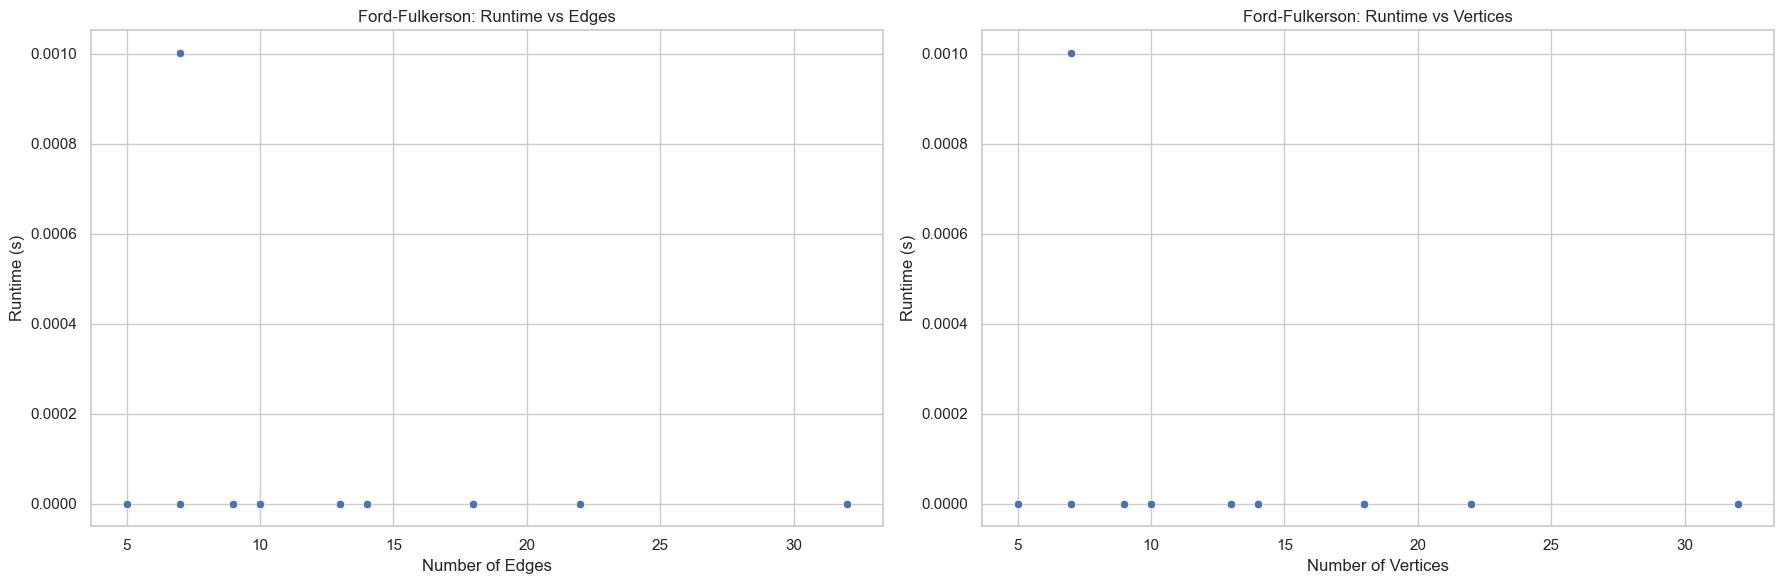

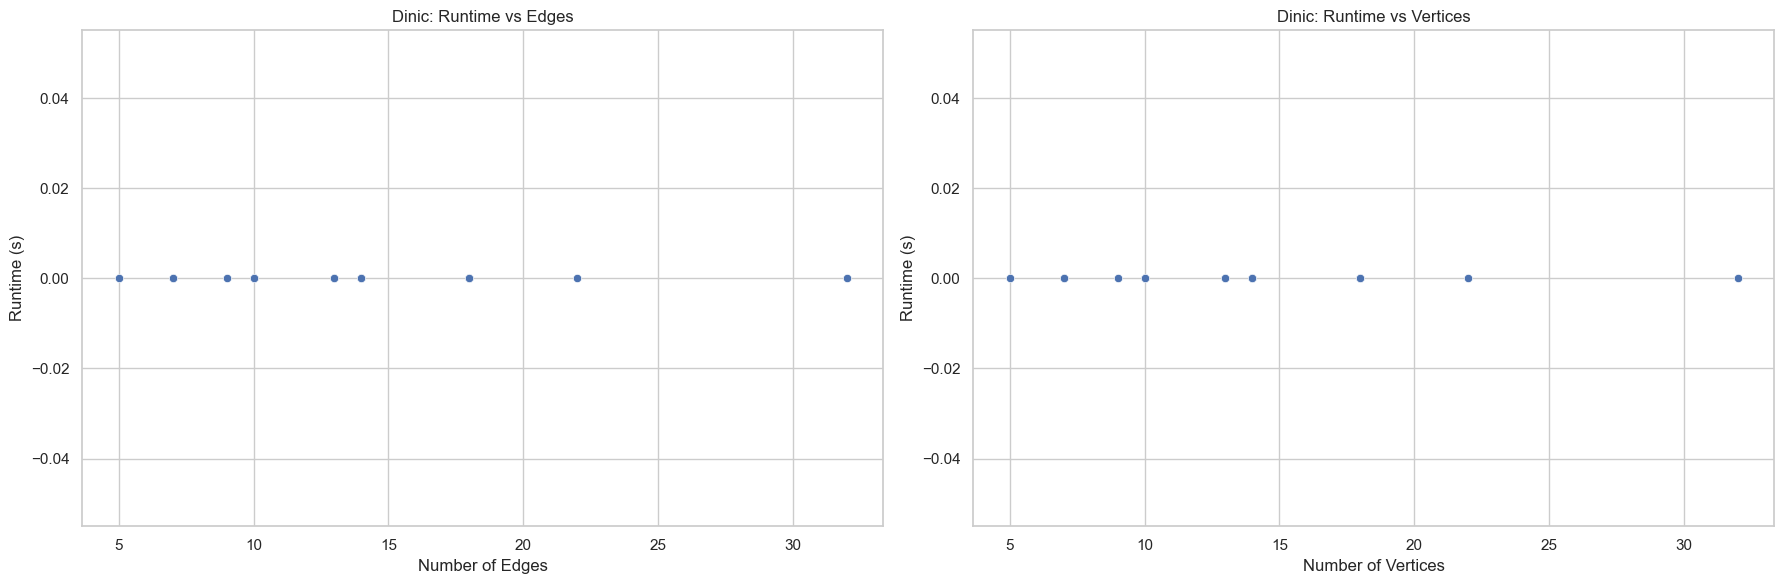

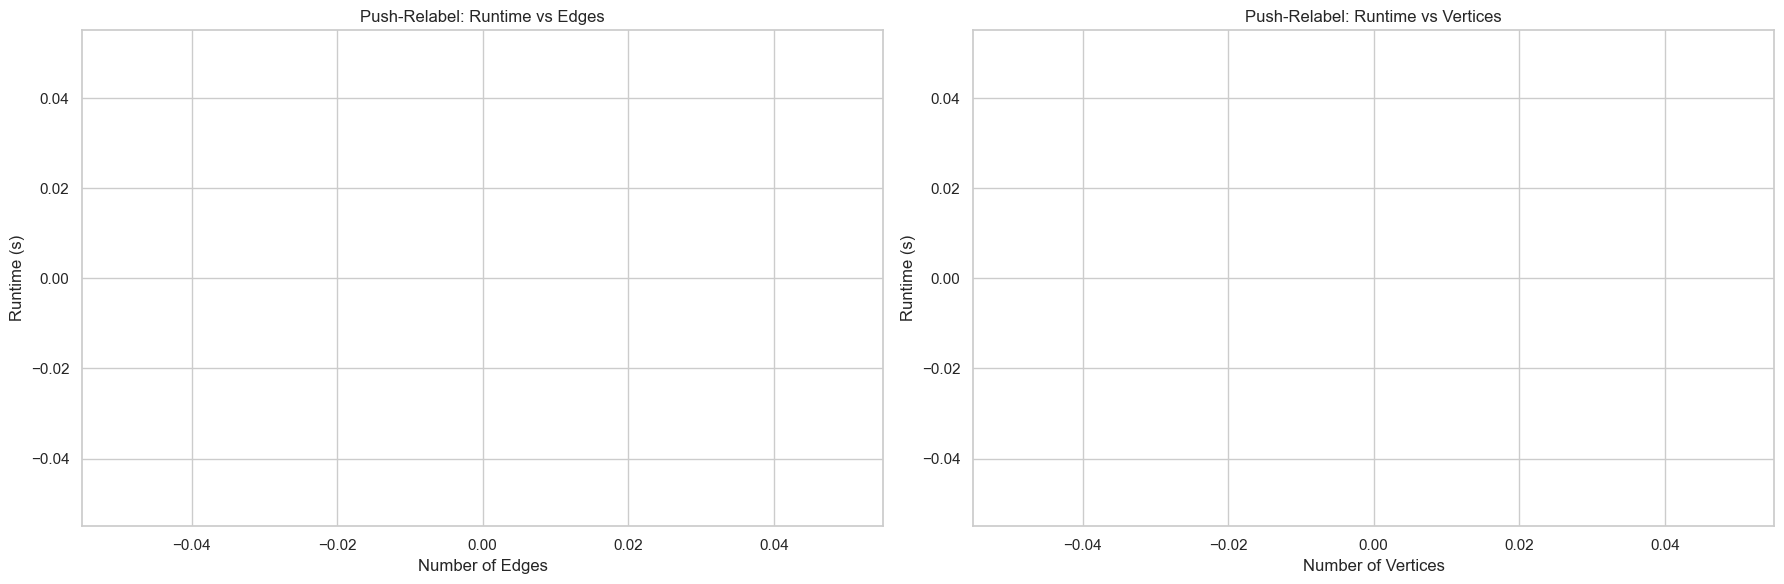

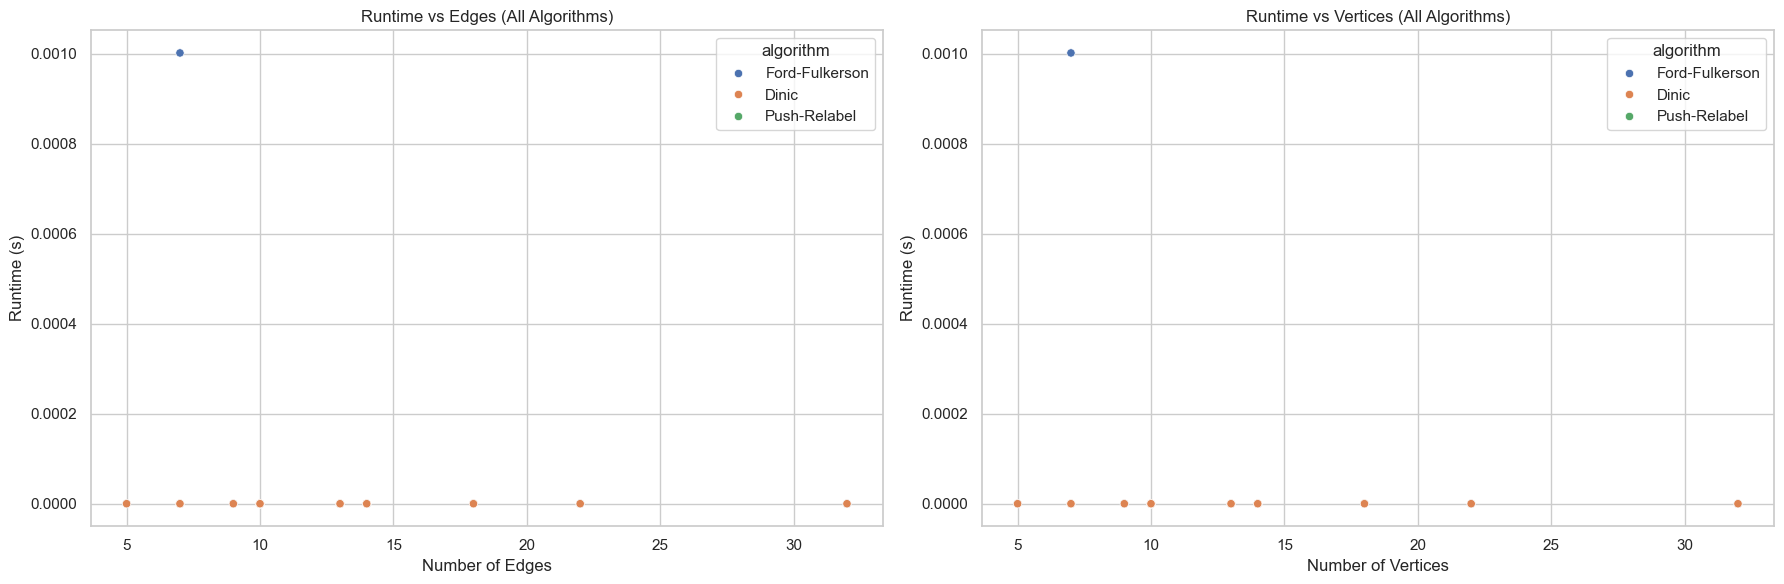

In [107]:
%matplotlib inline
# Plot runtime vs edges and runtime vs vertices for each algorithm separately (except BK)
for algo_name in results_df['algorithm'].unique():
    df_algo = results_df[results_df['algorithm'] == algo_name]
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.scatterplot(data=df_algo, x="edges", y="runtime", ax=axes[0])
    axes[0].set_title(f"{algo_name}: Runtime vs Edges")
    axes[0].set_xlabel("Number of Edges")
    axes[0].set_ylabel("Runtime (s)")
    
    sns.scatterplot(data=df_algo, x="vertices", y="runtime", ax=axes[1])
    axes[1].set_title(f"{algo_name}: Runtime vs Vertices")
    axes[1].set_xlabel("Number of Vertices")
    axes[1].set_ylabel("Runtime (s)")
    plt.tight_layout()
    plt.show()

# Plot all algorithms together (except BK)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(data=results_df, x="edges", y="runtime", hue="algorithm", ax=axes[0])
axes[0].set_title("Runtime vs Edges (All Algorithms)")
axes[0].set_xlabel("Number of Edges")
axes[0].set_ylabel("Runtime (s)")

sns.scatterplot(data=results_df, x="vertices", y="runtime", hue="algorithm", ax=axes[1])
axes[1].set_title("Runtime vs Vertices (All Algorithms)")
axes[1].set_xlabel("Number of Vertices")
axes[1].set_ylabel("Runtime (s)")
plt.tight_layout()
plt.show()

In [108]:
# Run BK algorithm on its own grid graphs and collect timing data
bk_sizes = [32, 64, 96, 128, 160, 192, 224, 256]
bk_times = []
bk_vertices = []
bk_edges = []

for S in bk_sizes:
    H = W = S
    g = bk_mod.build_grid_graph(H, W)
    V = 2 + H * W
    E = sum(len(g.adj[u]) for u in range(g.n))
    bk_vertices.append(V)
    bk_edges.append(E)
    start = time.time()
    g.max_flow(0, 1)
    end = time.time()
    bk_times.append(end - start)

bk_df = pd.DataFrame({
    "algorithm": "BK",
    "vertices": bk_vertices,
    "edges": bk_edges,
    "runtime": bk_times
})


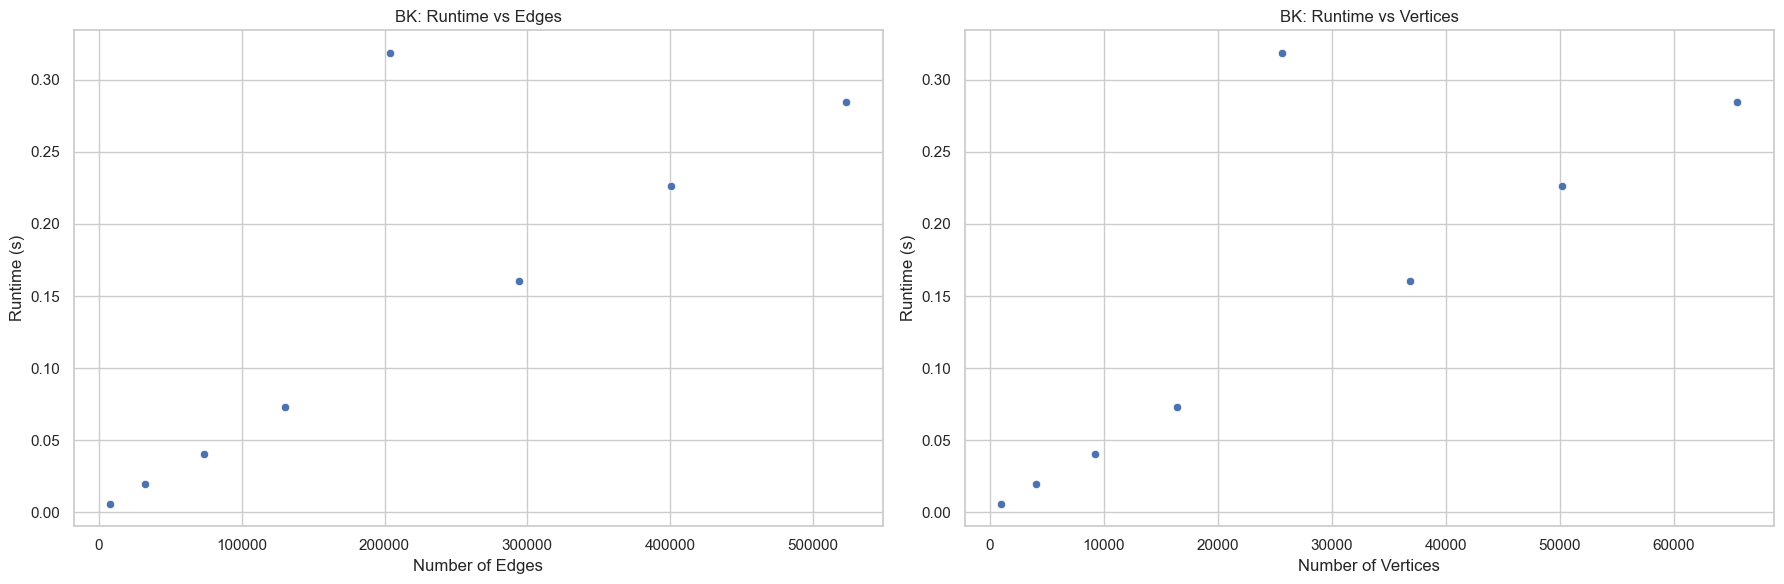

In [109]:
%matplotlib inline
# Plot BK results separately
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(data=bk_df, x="edges", y="runtime", ax=axes[0])
axes[0].set_title("BK: Runtime vs Edges")
axes[0].set_xlabel("Number of Edges")
axes[0].set_ylabel("Runtime (s)")

sns.scatterplot(data=bk_df, x="vertices", y="runtime", ax=axes[1])
axes[1].set_title("BK: Runtime vs Vertices")
axes[1].set_xlabel("Number of Vertices")
axes[1].set_ylabel("Runtime (s)")
plt.tight_layout()
plt.show()

## Summary and Interpretation

- The above plots show the empirical runtime of Dinic's, Push-Relabel, and Boykov-Kolmogorov (BK) algorithms as a function of the number of edges and vertices.
- Each algorithm's performance may vary depending on the graph structure and size.
- BK is run on grid graphs, while the others are run on a variety of graphs from the project datasets.
- For a fair comparison, ensure the graph types and sizes are as similar as possible.
- Further analysis can include memory usage, solution quality, and scalability on larger graphs.

---

*You can extend this notebook by adding Edmonds-Karp and more detailed analysis as needed.*